##Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Try to get data using Coinmarket API:

In [74]:
#Since this API is not free, no data is returned.
#So, don't run it
import requests

key = '0774dc30-e003-4388-9697-e40bd431af1e'

url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
full_url = requests.get(url + "?start=20130428&limit=5000&convert=USD&CMC_PRO_API_KEY=" + key)

#Load locally stored csv with data from yahoo (BTC-USD since 9/14/2014):

In [147]:
path = os.getcwd() 
bitcoin_market_info = pd.read_csv(path + "/exper_files/datasets/BTC-USD_yahoo.csv")

#Load locally stored csv with data from yahoo (ETH-USD since 8/7/2015):

In [148]:
path = os.getcwd() 
eth_market_info = pd.read_csv(path + "/exper_files/datasets/ETH-USD.csv")
eth_market_info['Date'] = pd.to_datetime(eth_market_info['Date'])

#Drop all data of bitcoin from 9/14/2014 to 8/7/2015 in order to have the same number of rows (bitcoin and ethereum):
spec_date = pd.to_datetime('2015-8-7')

bitcoin_market_info['Date'] = pd.to_datetime(bitcoin_market_info['Date'])
bitcoin_market_info = bitcoin_market_info[bitcoin_market_info['Date'] >= spec_date]

#Concatanate two datasets
#But first rename the columns
eth_market_info = eth_market_info.rename(columns={'Close':'eth_Close', 'Open':'eth_Open', 'High':'eth_High', \
                                                  'Low':'eth_Low', 'Adj Close':'eth_Adj_Close', 'Volume':'eth_Volume'})

bitcoin_market_info = bitcoin_market_info.rename(columns={'Close':'bit_Close', 'Open':'bit_Open', 'High':'bit_High', \
                                                  'Low':'bit_Low', 'Adj Close':'bit_Adj_Close', 'Volume':'bit_Volume'})

bitcoin_market_info = ((bitcoin_market_info.drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)

bitcoin_market_info = pd.concat([bitcoin_market_info, eth_market_info], axis=1)

Convert 'Date' column to type 'datetime64'

In [91]:
bitcoin_market_info['Date'] = pd.to_datetime(bitcoin_market_info['Date'])

Some values are null, so lets fill them with the values of the previous day:

In [149]:
bitcoin_market_info.fillna(method='ffill', inplace=True)

Compute the average 'Close' value for the last 7-days and 30-days(month) (finally these features return worse results): 

In [60]:
"""temp = bitcoin_market_info.copy()

#Drop the first 30 days to be able to compute average of month for the rows of the table
temp = temp[29:]

temp['mean_7days_Close'] = bitcoin_market_info['Close'].rolling(window=7).mean()

temp['mean_month_Close'] = bitcoin_market_info['Close'].rolling(window=30).mean()

bitcoin_market_info = temp.copy()"""

Compute the standard deviation of 'Close' value for the last 7-days and 30-days(month) (finally these features return worse results):

In [78]:
"""temp = bitcoin_market_info.copy()

#Drop the first 30 days to be able to compute average of month for the rows of the table
temp = temp[29:]

temp['std_7days_Close'] = bitcoin_market_info['Close'].rolling(window=7).std()

temp['std_month_Close'] = bitcoin_market_info['Close'].rolling(window=30).std()

bitcoin_market_info = temp.copy()"""

Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:

In [150]:
"""kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
          'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])}"""

kwards = {'eth_close_off_high': lambda x: 2 * (x['eth_High'] - x['eth_Close']) / (x['eth_High'] - x['eth_Low']) - 1,
          'eth_volatility': lambda x: (x['eth_High'] - x['eth_Low']) / (x['eth_Open']),
          'bit_close_off_high': lambda x: 2 * (x['bit_High'] - x['bit_Close']) / (x['bit_High'] - x['bit_Low']) - 1,
          'bit_volatility': lambda x: (x['bit_High'] - x['bit_Low']) / (x['bit_Open'])
          }

bitcoin_market_info = bitcoin_market_info.assign(**kwards)

#Split data

In [151]:
percent_train_set = 0.75
split_date = bitcoin_market_info.iloc[round(bitcoin_market_info.shape[0] * percent_train_set)]['Date']

training_set, val_test_set = bitcoin_market_info[bitcoin_market_info['Date'] < split_date], \
                         bitcoin_market_info[bitcoin_market_info['Date'] >= split_date]

percent_val_set = 0.5
split_date_val = val_test_set.iloc[round(val_test_set.shape[0] * percent_val_set)]['Date']

val_set, test_set = val_test_set[val_test_set['Date'] < split_date_val], \
                    val_test_set[val_test_set['Date'] >= split_date_val]


#Normalize inputs in windows

In [195]:
window_len = 10
LSTM_training_inputs = []
for i in range(len(training_set) - window_len):
    temp_set = training_set[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Date'], axis=1)
    temp_set = temp_set.drop(['bit_Open'], axis=1)
    temp_set = temp_set.drop(['bit_High'], axis=1)
    temp_set = temp_set.drop(['bit_Low'], axis=1)
    temp_set = temp_set.drop(['bit_Adj_Close'], axis=1)
    temp_set = temp_set.drop(['eth_Open'], axis=1)
    temp_set = temp_set.drop(['eth_High'], axis=1)
    temp_set = temp_set.drop(['eth_Low'], axis=1)
    temp_set = temp_set.drop(['eth_Adj_Close'], axis=1)
    

    for col in ['eth_Close', 'eth_Volume', 'bit_Close', 'bit_Volume']:
        temp_set[:][col] = temp_set[col] / temp_set[col].iloc[0] - 1

    LSTM_training_inputs.append(temp_set)

LSTM_training_outputs = (training_set['bit_Close'][window_len:].values / training_set['bit_Close'][:-window_len].values) - 1


LSTM_val_inputs=[]
for i in range(len(val_set) - window_len):
    temp_set = training_set[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Date'], axis=1)
    temp_set = temp_set.drop(['bit_Open'], axis=1)
    temp_set = temp_set.drop(['bit_High'], axis=1)
    temp_set = temp_set.drop(['bit_Low'], axis=1)
    temp_set = temp_set.drop(['bit_Adj_Close'], axis=1)
    temp_set = temp_set.drop(['eth_Open'], axis=1)
    temp_set = temp_set.drop(['eth_High'], axis=1)
    temp_set = temp_set.drop(['eth_Low'], axis=1)
    temp_set = temp_set.drop(['eth_Adj_Close'], axis=1)
    
    for col in ['eth_Close', 'eth_Volume', 'bit_Close', 'bit_Volume']:
        temp_set[:][col] = temp_set[col] / temp_set[col].iloc[0] - 1
        
    LSTM_val_inputs.append(temp_set)

LSTM_val_outputs = (val_set['bit_Close'][window_len:].values / val_set['bit_Close'][:-window_len].values) - 1



LSTM_test_inputs = []
for i in range(len(test_set) - window_len):
    temp_set = training_set[i:(i + window_len)].copy()
    temp_set = temp_set.drop(['Date'], axis=1)
    temp_set = temp_set.drop(['bit_Open'], axis=1)
    temp_set = temp_set.drop(['bit_High'], axis=1)
    temp_set = temp_set.drop(['bit_Low'], axis=1)
    temp_set = temp_set.drop(['bit_Adj_Close'], axis=1)
    temp_set = temp_set.drop(['eth_Open'], axis=1)
    temp_set = temp_set.drop(['eth_High'], axis=1)
    temp_set = temp_set.drop(['eth_Low'], axis=1)
    temp_set = temp_set.drop(['eth_Adj_Close'], axis=1)

    for col in ['eth_Close', 'eth_Volume', 'bit_Close', 'bit_Volume']:
        temp_set[:][col] = temp_set[col] / temp_set[col].iloc[0] - 1

    LSTM_test_inputs.append(temp_set)

LSTM_test_outputs = (test_set['bit_Close'][window_len:].values / test_set['bit_Close'][:-window_len].values) - 1


Convert DataFrames to numpy arrays

In [196]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_val_inputs = [np.array(LSTM_val_input) for LSTM_val_input in LSTM_val_inputs]
LSTM_val_inputs = np.array(LSTM_val_inputs)

LSTM_test_inputs = [np.array(LSTM_test_input) for LSTM_test_input in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

##Define LSTM model

In [256]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf


def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
   
    
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#Build and train LSTM model for one-day-ahead predictions

In [11]:
np.random.seed(202)

epochs = 20
batch_size = 1
neurons = 20

In [15]:
btcoin_model = build_model(LSTM_training_inputs, output_size=1, neurons=neurons)
hist = btcoin_model.fit(LSTM_training_inputs, LSTM_training_outputs, validation_data=(LSTM_val_inputs, LSTM_val_outputs),
                        epochs=epochs, batch_size=1, verbose=batch_size, shuffle=True)

Epoch 1/20
1779/1779 [==============================] - 5s 2ms/step - loss: 0.3654 - val_loss: 0.1207
Epoch 2/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0979 - val_loss: 0.1015
Epoch 3/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0950 - val_loss: 0.0967
Epoch 4/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0934 - val_loss: 0.0967
Epoch 5/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0939 - val_loss: 0.0955
Epoch 6/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0930 - val_loss: 0.0955
Epoch 7/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0941 - val_loss: 0.0958
Epoch 8/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0982 - val_loss: 0.0953
Epoch 9/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.0975 - val_loss: 0.0954
Epoch 10/20
1779/1779 [==============================] - 4s 2ms/step - loss: 0.090

Plot MAE

In [ ]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(hist.epoch, hist.history['loss'], color='b', label='Loss')
ax1.plot(hist.epoch, hist.history['val_loss'], color='orange', label='Val_loss')
ax1.set_xticks(range(0, len(hist.epoch)))
ax1.set_title('Training Error')
ax1.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax1.set_xlabel('#Epoch', fontsize=12)
plt.legend()
plt.show()

Plot predictions side-by-side with actual values for training set

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import datetime


In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

# Plot actual values
ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
         training_set['Close'][window_len:], label='Actual values', color='b')

# Plot predicted values
ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
         ((np.transpose(btcoin_model.predict(LSTM_training_inputs)) + 1) * training_set['Close'].values[:-window_len])[0],
         label='Predicted', color='g')

# Set plot title
ax1.set_title("Training Set: Single Timepoint Prediction")

# Set y label of plot
ax1.set_ylabel('Bitcoin price ($)', fontsize=12)

# Define bbox_to_anchor where MAE will be plotted
ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})

# Calculate and plot MAE
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(btcoin_model.predict(LSTM_training_inputs)) + 1) -
                                          (training_set['Close'].values[window_len:]) / (
                                              training_set['Close'].values[:-window_len]))),
             xy=(0.75, 0.9), xycoords='axes fraction',
             xytext=(0.75, 0.9), textcoords='axes fraction')

# Zoom in plot inside figure
axins = zoomed_inset_axes(ax1, 20., loc=10)  # Zoom_factor = 20., location = 10 (which means center)

axins.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
           training_set['Close'][window_len:], label='Actual values', color='b')

axins.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] < split_date]['Date'][window_len:]),
           ((np.transpose(btcoin_model.predict(LSTM_training_inputs)) + 1) * training_set['Close'].values[:-window_len])[0],
           label='Predicted', color='g')

axins.set_xlim([datetime.date(2016, 12, 1), datetime.date(2017, 2, 1)])
axins.set_ylim([700, 1400])
axins.set_xticklabels('')

mark_inset(ax1, axins, loc1=1, loc2=3, fc='none', ec='0.5')
plt.show()

Plot predictions side-by-side with actual values for test set

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))

ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date_val]['Date'][window_len:]),
         test_set['Close'][window_len:], label='Actual values', color='b')

ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date_val]['Date'][window_len:]),
         ((np.transpose(btcoin_model.predict(LSTM_test_inputs)) + 1) * test_set['Close'].values[:-window_len])[0],
         label='Predicted', color='g')

ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f' % np.mean(np.abs((np.transpose(btcoin_model.predict(LSTM_test_inputs)) + 1) - \
                                          (test_set['Close'].values[window_len:]) / (test_set['Close'].values[:-window_len]))),
             xy=(0.65, 0.95), xycoords='axes fraction',
             xytext=(0.65, 0.95), textcoords='axes fraction')

ax1.set_title('Test Set: Single Timepoint Prediction', fontsize=13)

ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)

plt.show()

#Build and train LSTM model for 5-days-ahead predictions

Normalize training outputs: 5 next prices normalized to 10th previous closing price

In [197]:
pred_range = 5

LSTM_ranged_training_outputs = []
for i in range(window_len, len(training_set['bit_Close']) - pred_range):
    LSTM_ranged_training_outputs.append((training_set['bit_Close'][i:i+pred_range].values/training_set['bit_Close'][training_set.index[0]+i-window_len]) - 1)

LSTM_ranged_training_outputs = np.array(LSTM_ranged_training_outputs)


LSTM_ranged_val_outputs = []
for i in range(window_len, len(val_set['bit_Close']) - pred_range):
    LSTM_ranged_val_outputs.append((val_set['bit_Close'][i:i+pred_range].values/val_set['bit_Close'][val_set.index[0]+i-window_len]) - 1)

LSTM_ranged_val_outputs = np.array(LSTM_ranged_val_outputs)

Build the model

In [288]:
neurons = 50

ranged_btcoin_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons=neurons, \
                                  optimizer=tf.keras.optimizers.RMSprop())

Train the model

In [289]:
np.random.seed(202)

epochs = 50
batch_size = 64

ranged_hist = ranged_btcoin_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs,
                                       validation_data=(LSTM_val_inputs[:-pred_range], LSTM_ranged_val_outputs), epochs=epochs, batch_size=batch_size, verbose=2, shuffle=True, workers=8)


Epoch 1/50
25/25 - 2s - loss: 0.1033 - val_loss: 0.1206
Epoch 2/50
25/25 - 0s - loss: 0.0904 - val_loss: 0.1218
Epoch 3/50
25/25 - 0s - loss: 0.0816 - val_loss: 0.1110
Epoch 4/50
25/25 - 0s - loss: 0.0757 - val_loss: 0.1178
Epoch 5/50
25/25 - 0s - loss: 0.0711 - val_loss: 0.1131
Epoch 6/50
25/25 - 0s - loss: 0.0671 - val_loss: 0.1116
Epoch 7/50
25/25 - 0s - loss: 0.0655 - val_loss: 0.1135
Epoch 8/50
25/25 - 0s - loss: 0.0635 - val_loss: 0.1110
Epoch 9/50
25/25 - 0s - loss: 0.0628 - val_loss: 0.1185
Epoch 10/50
25/25 - 0s - loss: 0.0608 - val_loss: 0.1079
Epoch 11/50
25/25 - 0s - loss: 0.0597 - val_loss: 0.1094
Epoch 12/50
25/25 - 0s - loss: 0.0595 - val_loss: 0.1136
Epoch 13/50
25/25 - 0s - loss: 0.0580 - val_loss: 0.1082
Epoch 14/50
25/25 - 0s - loss: 0.0578 - val_loss: 0.1069
Epoch 15/50
25/25 - 0s - loss: 0.0563 - val_loss: 0.1147
Epoch 16/50
25/25 - 0s - loss: 0.0566 - val_loss: 0.1102
Epoch 17/50
25/25 - 0s - loss: 0.0559 - val_loss: 0.1092
Epoch 18/50
25/25 - 0s - loss: 0.0551 - 

Plot MAE:

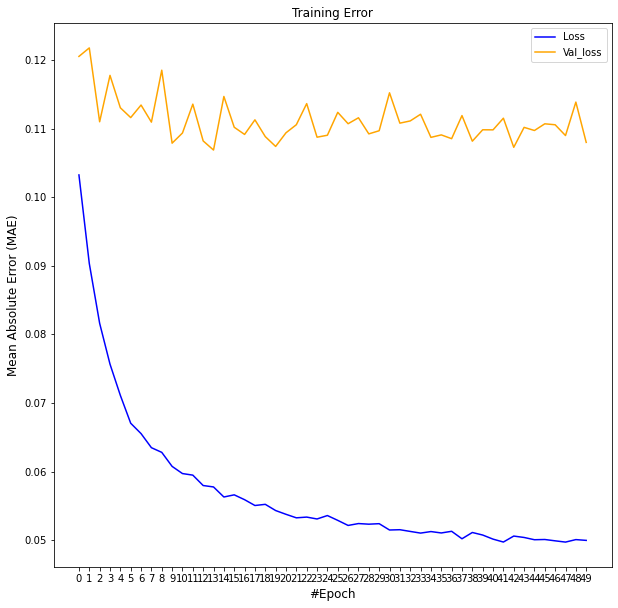

In [290]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

ax1.plot(ranged_hist.epoch, ranged_hist.history['loss'], color='b', label='Loss')
ax1.plot(ranged_hist.epoch, ranged_hist.history['val_loss'], color='orange', label='Val_loss')
ax1.set_xticks(range(0, len(ranged_hist.epoch)))
ax1.set_title('Training Error')
ax1.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
ax1.set_xlabel('#Epoch', fontsize=12)
plt.legend()
plt.show()

#Get predictions and reformat array

In [291]:
pred_prices = (ranged_btcoin_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range] + 1) *\
              test_set['bit_Close'].values[:-(window_len + pred_range)][::pred_range].reshape(int(np.ceil((len(LSTM_test_inputs) -
                                                                                            pred_range)/float(pred_range))), 1)



#Plot predictions side-by-side with actual values

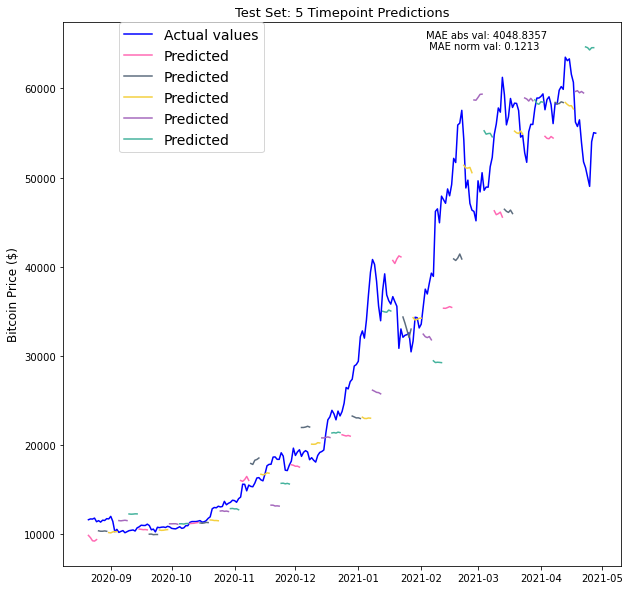

In [292]:
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F", "#A569BD", "#45B39D"]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date_val]['Date'][window_len:]),
         test_set['bit_Close'][window_len:], label='Actual values', color='b')

for i, pred in enumerate(pred_prices):

    if i < pred_range: #Print label=predicted for the first time

        ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date_val]['Date'][window_len:])[(i * pred_range):((i * pred_range) + pred_range)],
                 pred, color=pred_colors[i % pred_range], label='Predicted')

    else: #Dont print label=predicted again

        ax1.plot(pd.to_datetime(bitcoin_market_info[bitcoin_market_info['Date'] >= split_date_val]['Date'][window_len:])[
                 (i * pred_range):((i * pred_range) + pred_range)],
                 pred, color=pred_colors[i % pred_range])

ax1.set_title('Test Set: 5 Timepoint Predictions', fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})

ax1.legend(loc=2, bbox_to_anchor=(0.1, 1), borderaxespad=0., prop={'size': 14})

res = ((len(test_set['bit_Close'].values[window_len:])-window_len)%pred_range)
test_set_len = len(test_set['bit_Close'])

all_preds_plus1 = (((ranged_btcoin_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range] + 1)).reshape(-1)) 

MAE_norm_val = np.mean( np.abs(all_preds_plus1 - (test_set['bit_Close'].values[window_len:(test_set_len-res)]/test_set['bit_Close'].values[:-(window_len+res)])))

MAE_abs_val = np.mean(np.abs((pred_prices.reshape(-1)) - (test_set['bit_Close'].values[window_len:test_set_len-res])))


ax1.annotate('MAE abs val: %.4f \n MAE norm val: %.4f' % (MAE_abs_val, MAE_norm_val),
             xy=(0.65, 0.95), xycoords='axes fraction',
             xytext=(0.65, 0.95), textcoords='axes fraction')
plt.show()

##Try to make predictions for earliest period:

Keep data for a specific date and before:

In [ ]:
spec_date = pd.to_datetime('2017-11-01')

spec_date_bitcoin_market_info = bitcoin_market_info[bitcoin_market_info['Date'] <= spec_date]

Split data:

In [ ]:
def split_data(perc_train_set, currency_data):
        
        splt_date = currency_data.iloc[round(currency_data.shape[0] * perc_train_set)]['Date']
        tr_set, tst_set = currency_data[currency_data['Date'] < splt_date], \
                         currency_data[currency_data['Date'] >= splt_date]
        
        return tr_set, tst_set, splt_date


In [ ]:
percent_train_set = 0.95

training_set, test_set, split_date= split_data(percent_train_set, spec_date_bitcoin_market_info)

Normalize training inputs and outputs:

In [ ]:
def norm_train_test_in_out(prd_range, wind_len, tr_set, tst_set, feats):
    
    LSTM_tr_in = []
    for i in range(len(tr_set) - wind_len):
        tmp_set = tr_set[i:(i + wind_len)].copy()
        tmp_set = tmp_set.drop(['Date'], axis=1)

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1

        LSTM_tr_in.append(tmp_set)
    
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    LSTM_test_in = []
    for i in range(len(tst_set) - wind_len):
        tmp_set = tst_set[i:(i + wind_len)].copy()
        tmp_set = tmp_set.drop(['Date'], axis=1)

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1

        LSTM_test_in.append(tmp_set)
        
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(tr_set['Close']) - prd_range):
        LSTM_rangd_train_out.append((tr_set['Close'][i:i+prd_range].values/tr_set['Close'][i-wind_len]) - 1)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    return LSTM_rangd_train_out, LSTM_tr_in, LSTM_test_in

In [ ]:
pred_range = 5
window_len = 10
features = ['Close']

LSTM_ranged_training_outputs, LSTM_training_inputs, LSTM_test_inputs = norm_train_test_in_out(pred_range, window_len, 
                                                                                              training_set, test_set, 
                                                                                              features)

Bulid and train model:

In [ ]:
def build_and_train_model(epchs, btch_size, neurs, prd_range, LSTM_train_in, LSTM_rangd_train_out, shffl):

    rnged_btcoin_model = build_model(LSTM_train_in, output_size=prd_range, neurons=neurs)
    
    np.random.seed(202)

    rnged_hist = rnged_btcoin_model.fit(LSTM_train_in[:-prd_range], LSTM_rangd_train_out,
                                      epochs=epchs, batch_size=btch_size, verbose=1, shuffle=shffl)
    
    return rnged_btcoin_model, rnged_hist

In [ ]:
epochs = 2
batch_size = 1
neurons = 20
shuffle = True

ranged_btcoin_model, ranged_hist = build_and_train_model(epochs, batch_size, neurons, pred_range, LSTM_training_inputs,
                                                        LSTM_ranged_training_outputs, True)

Get predictions:

In [ ]:
def get_preds(rnged_btcoin_model, LSTM_test_in, prd_range, tst_set, wind_len):
    prd_prices = (rnged_btcoin_model.predict(LSTM_test_in)[:-prd_range][::prd_range] + 1) *\
              tst_set['Close'].values[:-(wind_len + prd_range)][::prd_range].reshape(int(np.ceil((len(LSTM_test_in) -
                                                                                            prd_range)/float(prd_range))), 1)
    
    return prd_prices

In [ ]:
pred_prices = get_preds(ranged_btcoin_model, LSTM_test_inputs, pred_range, test_set, window_len)

Plot predictions:

In [ ]:
def plot_preds(currency_data, splt_date, wind_len, prd_range, tst_set, prd_prices):
    
    pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F", "#A569BD", "#45B39D"]

    fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))

    ax1.plot(pd.to_datetime(currency_data[currency_data['Date'] >= splt_date]['Date'][wind_len:]),
             tst_set['Close'][wind_len:], label='Actual values', color='b')

    for i, pred in enumerate(prd_prices):

        if i < prd_range: #Print label=predicted for the first time

            ax1.plot(pd.to_datetime(currency_data[currency_data['Date'] >= splt_date]['Date'][wind_len:])[(i * prd_range):((i * prd_range) + prd_range)],
                     pred, color=pred_colors[i % prd_range], label='Predicted')

        else: #Dont print label=predicted again

            ax1.plot(pd.to_datetime(currency_data[currency_data['Date'] >= splt_date]['Date'][wind_len:])[
                     (i * prd_range):((i * prd_range) + prd_range)],
                     pred, color=pred_colors[i % prd_range])

    ax1.set_title('Test Set: 5 Timepoint Predictions', fontsize=13)
    ax1.set_ylabel('Bitcoin Price ($)', fontsize=12)
    ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
    plt.show()

In [ ]:
plot_preds(spec_date_bitcoin_market_info, split_date, window_len, pred_range, test_set, pred_prices)